# EDA Notebook

Emplearemos el DataSet del INE sobre Camping para realizar un estudio sobre la ocupación de los camping durante estos últimos años y así obtener conclusiones acerca de el ratio de ocupación, la saturación del mercado o el ratio de empleados por parcelas y pernoctas.

## 1. Importar librerías necesarias
Importar pandas, numpy, matplotlib y seaborn para el análisis y visualización de datos.

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Cargar el archivo CSV
Solicitar al usuario la ruta del archivo .csv y cargarlo en un DataFrame de pandas.

In [68]:
# Change this path to point to your data file
file_path = "../data/raw/2064.csv"
df = pd.read_csv(file_path, sep=";", encoding="latin-1", na_values=[".", ""])

## 3. Visualizar las primeras filas del dataset
Mostrar las primeras filas del DataFrame usando head() para obtener una vista general de los datos.

In [69]:
df.head()

,ï»¿Provincias con mayor nÃºmero de pernoctaciones,Establecimientos y personal empleado (parcelas),Periodo,Total
0,02 Albacete,NÃºmero de establecimientos abiertos estimados,2025M12,NaN
1,02 Albacete,NÃºmero de establecimientos abiertos estimados,2025M11,NaN
2,02 Albacete,NÃºmero de establecimientos abiertos estimados,2025M10,6
3,02 Albacete,NÃºmero de establecimientos abiertos estimados,2025M09,5
4,02 Albacete,NÃºmero de establecimientos abiertos estimados,2025M08,7


## 4. Explorar información general del dataset
Utilizar info() y shape para mostrar información sobre el número de filas, columnas y tipos de datos.

In [70]:
df.info()
print(f"Número de filas: {df.shape[0]}")
print(f"Número de columnas: {df.shape[1]}")

<class 'pandas.DataFrame'>
RangeIndex: 88200 entries, 0 to 88199
Data columns (total 4 columns):
 #   Column                                             Non-Null Count  Dtype
---  ------                                             --------------  -----
 0   ï»¿Provincias con mayor nÃºmero de pernoctaciones  88200 non-null  str  
 1   Establecimientos y personal empleado (parcelas)    88200 non-null  str  
 2   Periodo                                            88200 non-null  str  
 3   Total                                              51835 non-null  str  
dtypes: str(4)
memory usage: 2.7 MB
Número de filas: 88200
Número de columnas: 4


# (EXTRA 1). Limpieza primaria del dataset
Realizamos una primera limpieza exploratoria del dataset para tratar los datos a partir del 2017. Para ello, debemos de tratar el campo que almacena este dato como un entero

In [71]:
df["year"] = df["Periodo"].str[:4].astype(int)
df = df[df["year"] >= 2017]

Viendo los datos de los otros campos del notebook, vemos que quedan **37800** filas dentro de el CSV limpio, lo cual tiene sentido puesto que 50 × 7 × 12 × 9 ≈ 37.800 (50 provincias, 7 variables, 12 meses, 9 años)

## Convertir TOTAL en float sin romper los datos

Primeramente vamos a ver que datos tenemos para ver que limpieza poder aplicar

In [72]:
df["Total"].unique()[:20]

<StringArray>
[    nan,     '6',     '5',     '7',     '4',     '3',     '0',     '8',
     '9', '3.541', '2.878', '3.623', '3.313', '3.099', '2.915', '2.912',
 '2.611', '3.028', '3.109', '3.310']
Length: 20, dtype: str

Visto estos resultados, tenemos que realizar una transforamción a float pero primeramente tenemos que quitar los puntos de miles, para que no sean tratados como decimales. 

In [73]:
# Eliminar puntos de miles
df["Total"] = df["Total"].str.replace(".", "", regex=False)

# Convertir a numérico
df["Total"] = pd.to_numeric(df["Total"], errors="coerce")

# Verificar
print(df["Total"].dtype)
df["Total"].head(10)

float64


0    NaN
1    NaN
2    6.0
3    5.0
4    7.0
5    6.0
6    5.0
7    5.0
8    5.0
9    4.0
Name: Total, dtype: float64

In [74]:
df["Total"].max()

np.float64(937197.0)

## Convertir PERIODO en fecha real


In [75]:
# Extraer mes
df["month"] = df["Periodo"].str[5:7].astype(int)

# Crear fecha
df["date"] = pd.to_datetime(dict(year=df["year"], month=df["month"], day=1))

df[["Periodo", "date"]].head()

,Periodo,date
0,2025M12,2025-12-01
1,2025M11,2025-11-01
2,2025M10,2025-10-01
3,2025M09,2025-09-01
4,2025M08,2025-08-01


## Pivotar variables
Actualmente las 7 métricas están en filas, pero necesitamos convertirlas en columnas
El objetivo sería obtener algo de este estilo: 
|Provincia|Fecha|Establecimientos|Parcelas|Ocupacion|Personal|

Para ello primeramente veamos como se llaman exactamente las variables

In [76]:
df["Establecimientos y personal empleado (parcelas)"].unique()

<StringArray>
[  'NÃºmero de establecimientos abiertos estimados',
                      'NÃºmero de plazas estimadas',
                              'NÃºmero de parcelas',
                                'Parcelas ocupadas',
                 'Grado de ocupaciÃ³n por parcelas',
 'Grado de ocupaciÃ³n de parcelas en fin de semana',
                                'Personal empleado']
Length: 7, dtype: str

Primeramente, vamos a renombrar las columnas con nombres largos a nombres más simples

In [77]:
df = df.rename(columns={
    "ï»¿Provincias con mayor nÃºmero de pernoctaciones": "provincia",
    "Establecimientos y personal empleado (parcelas)": "variable"
})

In [ ]:
df.columns

Y finalmente, lo que vamos a hacer es que
* Para cada provincia
* Para cada fecha

Cada variable pasará a ser una columna y su valor será total


In [78]:
df_pivot = df.pivot_table(
    index=["provincia", "date"],
    columns="variable",
    values="Total",
    aggfunc="first"
).reset_index()

df_pivot.head()

variable,provincia,date,Grado de ocupaciÃ³n de parcelas en fin de semana,Grado de ocupaciÃ³n por parcelas,NÃºmero de establecimientos abiertos estimados,NÃºmero de parcelas,NÃºmero de plazas estimadas,Parcelas ocupadas,Personal empleado
0,01 Araba/Ãlava,2024-03-01,NaN,NaN,3.0,500.0,1586.0,7876.0,34.0
1,01 Araba/Ãlava,2024-04-01,NaN,NaN,3.0,540.0,1712.0,8107.0,59.0
2,01 Araba/Ãlava,2024-05-01,NaN,NaN,3.0,531.0,1712.0,9050.0,65.0
3,01 Araba/Ãlava,2024-06-01,77.0,NaN,3.0,540.0,1712.0,9110.0,72.0
4,01 Araba/Ãlava,2024-07-01,NaN,NaN,3.0,531.0,1712.0,10040.0,72.0


Finalmente, lo que vamos a hacer es cambiar los nombres de las columnas para que sea más fácil trabajar con ellas:

In [79]:
df_pivot = df_pivot.rename(columns={
    "NÃºmero de establecimientos abiertos estimados": "Establecimientos",
    "NÃºmero de plazas estimadas": "Plazas",
    "NÃºmero de parcelas": "Parcelas",
    "Parcelas ocupadas": "Parcelas_Ocupadas",
    "Grado de ocupaciÃ³n por parcelas": "Ocupacion_Parcelas",
    "Grado de ocupaciÃ³n de parcelas en fin de semana": "Ocupacion_finde",
    "Personal empleado": "Personal"
})

df_pivot.head()

variable,provincia,date,Ocupacion_finde,Ocupacion_Parcelas,Establecimientos,Parcelas,Plazas,Parcelas_Ocupadas,Personal
0,01 Araba/Ãlava,2024-03-01,NaN,NaN,3.0,500.0,1586.0,7876.0,34.0
1,01 Araba/Ãlava,2024-04-01,NaN,NaN,3.0,540.0,1712.0,8107.0,59.0
2,01 Araba/Ãlava,2024-05-01,NaN,NaN,3.0,531.0,1712.0,9050.0,65.0
3,01 Araba/Ãlava,2024-06-01,77.0,NaN,3.0,540.0,1712.0,9110.0,72.0
4,01 Araba/Ãlava,2024-07-01,NaN,NaN,3.0,531.0,1712.0,10040.0,72.0


In [80]:
df_clean[df_clean["provincia"].str.startswith("15")][
    ["provincia", "date", "Ocupacion_Parcelas"]
].head(20)

variable,provincia,date,Ocupacion_Parcelas
988,"15 CoruÃ±a, A",2017-01-01,NaN
989,"15 CoruÃ±a, A",2017-02-01,NaN
990,"15 CoruÃ±a, A",2017-03-01,NaN
991,"15 CoruÃ±a, A",2017-04-01,NaN
992,"15 CoruÃ±a, A",2017-05-01,NaN
993,"15 CoruÃ±a, A",2017-06-01,NaN
994,"15 CoruÃ±a, A",2017-07-01,NaN
995,"15 CoruÃ±a, A",2017-08-01,NaN
996,"15 CoruÃ±a, A",2017-09-01,NaN
997,"15 CoruÃ±a, A",2017-10-01,NaN


## 5. Describir variables numéricas y categóricas
Usar describe() para variables numéricas y value_counts() para variables categóricas.

In [81]:
# Numerical variables
df.describe()

# Categorical values (Example for a columnn)
# df['category_column'].value_counts()

,Total,year,month,date
count,17372.000000,37800.000000,37800.000000,37800
mean,13849.915784,2021.000000,6.500000,2021-06-16 08:26:40
min,0.000000,2017.000000,1.000000,2017-01-01 00:00:00
25%,50.750000,2019.000000,3.750000,2019-03-24 06:00:00
50%,1551.500000,2021.000000,6.500000,2021-06-16 00:00:00
75%,8026.750000,2023.000000,9.250000,2023-09-08 12:00:00
max,937197.000000,2025.000000,12.000000,2025-12-01 00:00:00
std,45196.226102,2.582023,3.452098,NaN


## 6. Visualizar valores nulos y duplicados
Identificar y visualizar la cantidad de valores nulos y filas duplicadas en el dataset.

In [82]:
# Null values
df.isnull().sum()

# Duplicated rows
df.duplicated().sum()

np.int64(0)

# 11. TESTs
## cleaning.py


Vamos a usar una función dada por ChatGPT que lo que hace es: "Python busca módulos un nivel más arriba"

In [1]:
import sys
import os

# Añadir la raíz del proyecto al path
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
from src.io import load_csv
from src.cleaning import clean
from src.config import RAW_PATH

df_raw = load_csv(RAW_PATH)
df_clean = clean(df_raw)

df_clean.head()
df_clean.shape

(3484, 9)

## features.py


In [ ]:
from src.features import build_features

df_final = build_features(df_clean)

df_final.head()
df_final.tail()

In [6]:
from src.features import build_features

df_final = build_features(df_clean)

df_final[["date", "Parcelas", "Parcelas_Ocupadas", "ocupacion_real"]].head()

variable,date,Parcelas,Parcelas_Ocupadas,ocupacion_real
0,2024-03-01,500.0,7876.0,0.508129
1,2024-04-01,540.0,8107.0,0.500432
2,2024-05-01,531.0,9050.0,0.549784
3,2024-06-01,540.0,9110.0,0.562346
4,2024-07-01,531.0,10040.0,0.609926


In [ ]:
df_final.describe()

# Bloque Estratégico de A Coruña
El objetivo del bloque es responder a la siguiente pregunta
    **¿Existe presión de demanda suficiente en A Coruña como para justificar una nueva apertura o amplicación?**

Para ello, necesitamos analizar tres variables clave:
* 1️⃣ Evolución de la ocupación
* 2️⃣ Evolución de la oferta (establecimientos)
* 3️⃣ Intensidad laboral (impacto operativo)

Primeramente, **aislaremos A Coruña**, pero para ello vamos a emplear el código de A Coruña en vez de su nombre puesto que las ñ nos dan problemas y los códigos de provincia son únicos

In [8]:
coruna = df_final[df_final["provincia"].str.startswith("15")].copy()
coruna = coruna.sort_values("date")

Ahora podemos trabajar con la provincia de A Coruña facilmente.

*Después de haber trabajado con los datos, hemos apreciado un error en los datos del INE dado que consideran Parcelas=Parcelas_Ocupadas en todos los campos, por lo que los datos no son coherentes para ese año. De este modo, la retiraremos de los análisis cuando tratemos la ocupacion*

In [23]:
# Excluir 2019 solo para análisis de ocupación
coruna_ocup = coruna[coruna["date"].dt.year != 2019].copy()

## 1. Evolución ocupación anual


In [55]:
ocupacion_anual = (
    coruna_ocup
    .groupby(coruna_ocup["date"].dt.year)["ocupacion_real"]
    .mean()
)

ocupacion_anual

date
2017    0.150130
2018    0.162950
2020    0.121727
2021    0.138212
2022    0.153072
2023    0.159629
2024    0.152471
2025    0.190918
Name: ocupacion_real, dtype: float64

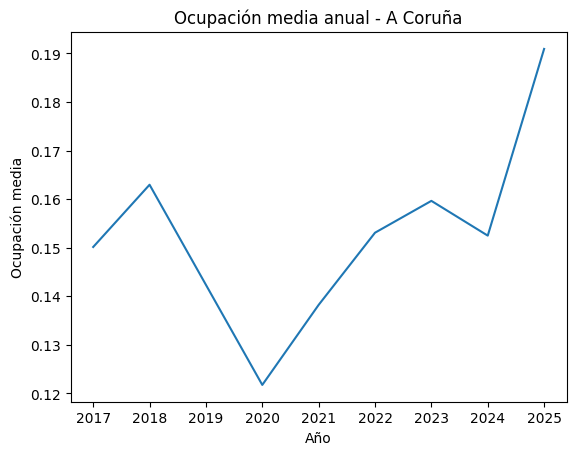

In [56]:
import matplotlib.pyplot as plt

plt.figure()
ocupacion_anual.plot()
plt.title("Ocupación media anual - A Coruña")
plt.xlabel("Año")
plt.ylabel("Ocupación media")
plt.show()

Lo que vemos:
	•	2017–2018 → mercado estable (~15–16%)
	•	2019 → caída fuerte
	•	2020 → recuperación parcial
	•	2021–2023 → tendencia claramente alcista
	•	2025 → máximo histórico (~19%)

📌 Conclusión estratégica:

👉 Desde 2021 hay una tendencia estructural creciente.
👉 El mercado post-pandemia no solo se recupera, sino que mejora.
👉 2025 marca el mejor nivel de ocupación del periodo.

Esto es señal positiva para expansión.


## Estacionalidad mensual

In [47]:
ocupacion_mensual_media = (
    coruna
    .groupby(coruna["date"].dt.month)["ocupacion_real"]
    .mean()
)

ocupacion_mensual_media

date
1     0.032645
2     0.068721
3     0.072387
4     0.086600
5     0.120303
6     0.183611
7     0.310085
8     0.383511
9     0.168864
10    0.095527
11    0.068796
12    0.064136
Name: ocupacion_real, dtype: float64

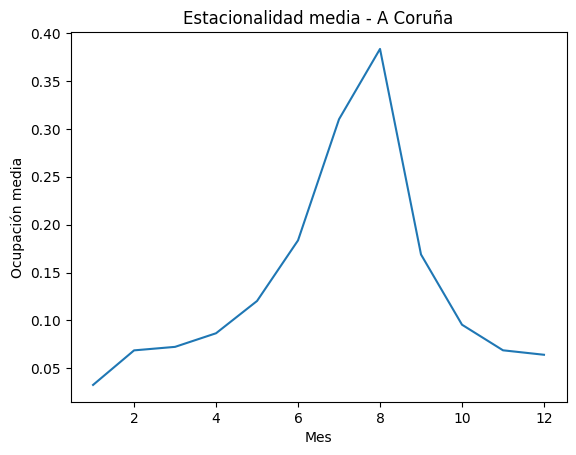

In [48]:
plt.figure()
ocupacion_mensual_media.plot()
plt.title("Estacionalidad media - A Coruña")
plt.xlabel("Mes")
plt.ylabel("Ocupación media")
plt.show()

Patrón clarísimo:
	•	Enero–Marzo → ocupación residual (3–8%)
	•	Abril–Junio → subida progresiva
	•	Julio → fuerte
	•	Agosto → pico absoluto (~38–40%)
	•	Septiembre → caída brusca
	•	Octubre–Diciembre → baja ocupación

📌 Implicación para tu negocio:

✔ Temporada real fuerte: Junio–Septiembre
✔ Pico crítico: Agosto
✔ Julio muy sólido
✔ Mayo empieza a ser interesante

Esto te sirve para:
	•	Planificar contratación temporal
	•	Ajustar tarifas dinámicas
	•	Optimizar inversión en temporada alta

## Evolución estructural del mercado

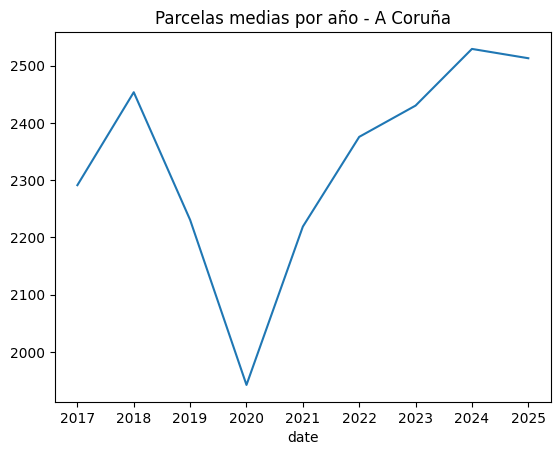

In [49]:
parcelas_anual = (
    coruna
    .groupby(coruna["date"].dt.year)["Parcelas"]
    .mean()
)

parcelas_anual.plot(title="Parcelas medias por año - A Coruña")
plt.show()

	•	2020 → caída fuerte (COVID)
	•	2021–2024 → crecimiento claro
	•	2025 → ligera estabilización

📌 Interpretación:

El mercado está ampliando oferta.



🔥 Cruce estratégico clave

Si la oferta (parcelas) crece…
Y la ocupación también crece…

👉 Eso significa que la demanda está creciendo más rápido que la oferta.

Eso es una señal de mercado fuerte, no saturado.


## Ocupación media en temporada alta en A Coruña

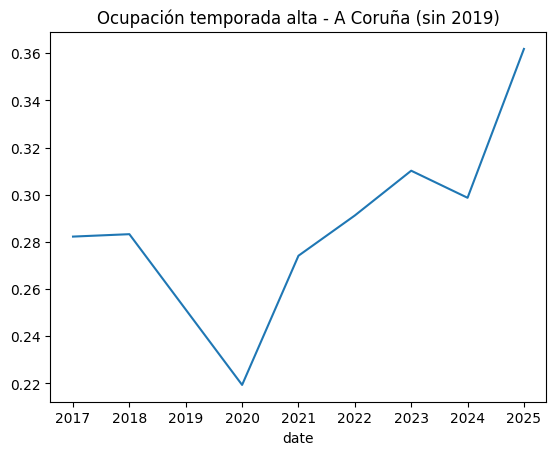

In [57]:
temporada_alta = coruna_ocup[
    coruna_ocup["date"].dt.month.isin([6,7,8,9])
]

ocupacion_alta_anual = (
    temporada_alta
    .groupby(temporada_alta["date"].dt.year)["ocupacion_real"]
    .mean()
)

plt.figure()
ocupacion_alta_anual.plot()
plt.title("Ocupación temporada alta - A Coruña (sin 2019)")
plt.show()

🧠 Interpretación estratégica real

1️⃣ La temporada alta está fortalecida

No es solo recuperación post-COVID.

Hay una tendencia estructural ascendente.

⸻

2️⃣ El mercado absorbe más oferta

Recordemos:
	•	Las parcelas medias por año han crecido
	•	Y la ocupación también ha crecido

Eso indica que la demanda está creciendo más rápido que la oferta.

No es saturación.

Es expansión del mercado.

⸻

3️⃣ Agosto sigue siendo cuello de botella

Según el gráfico mensual anterior:
	•	Agosto ≈ 38–40%
	•	Julio ≈ 30–32%
    

## Ratio de ocupación en temporada alta

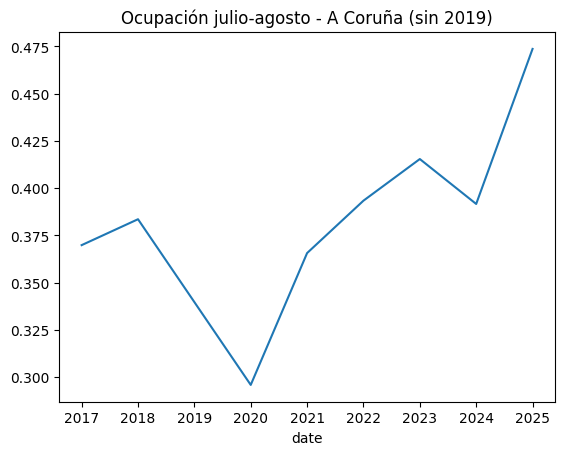

In [58]:
julio_agosto = coruna_ocup[
    coruna_ocup["date"].dt.month.isin([7,8])
]

ocupacion_julio_agosto = (
    julio_agosto
    .groupby(julio_agosto["date"].dt.year)["ocupacion_real"]
    .mean()
)

plt.figure()
ocupacion_julio_agosto.plot()
plt.title("Ocupación julio-agosto - A Coruña (sin 2019)")
plt.show()

🧠 Interpretación estratégica seria

1️⃣ Hay tendencia estructural alcista

Desde 2020:

30% → 46%

Eso es +16 puntos en 5 años.

Eso no es ruido.
Eso es crecimiento estructural.

⸻

2️⃣ El pico ya empieza a acercarse a tensión

Un 46% de ocupación media en julio-agosto:

Recuerda que esto es promedio provincial.

Eso implica que muchos campings buenos estarán:
	•	Muy por encima del promedio
	•	Cerca del 70–80% real
	•	Algunos incluso llenos en agosto

El promedio provincial diluye los mejores establecimientos.

⸻

3️⃣ Esto es lo realmente interesante

La oferta (parcelas) ha crecido.
Pero la ocupación también.

Eso significa:

👉 El mercado no está saturado.
👉 La demanda está absorbiendo nueva capacidad.
👉 Hay presión creciente en temporada alta.


In [52]:
crecimiento = (
    ocupacion_julio_agosto.loc[2025] /
    ocupacion_julio_agosto.loc[2020]
) - 1

crecimiento

np.float64(0.6013704646719169)

# Visualizaciones

## 1. Comparación de ocupación en provincias similares
Miraremos la evolución de la ocupación en provincias similares a A Coruña por servicios, localización y ambiente. En particular, para nuestro estudio emplearemos las provincia de Pontevedra y las comunidades del Principado de Asturias y Cantabria:

In [59]:
# Dataset general
df_plot = df_final.copy()

# Dataset sin 2019 SOLO para análisis de ocupación
df_plot_ocup = df_plot[df_plot["date"].dt.year != 2019].copy()

<Figure size 640x480 with 0 Axes>

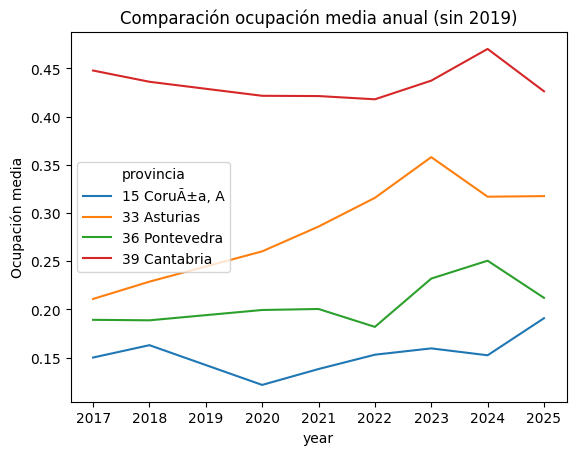

In [60]:
provincias_objetivo = ["15", "36", "33", "39"]  # Coruña, Pontevedra, Asturias, Cantabria

comparativa = df_plot_ocup[
    df_plot_ocup["provincia"].str[:2].isin(provincias_objetivo)
].copy()

comparativa["year"] = comparativa["date"].dt.year

ocupacion_comparativa = (
    comparativa
    .groupby(["year", "provincia"])["ocupacion_real"]
    .mean()
    .unstack()
)

plt.figure()
ocupacion_comparativa.plot()
plt.title("Comparación ocupación media anual (sin 2019)")
plt.ylabel("Ocupación media")
plt.show()

📊 1️⃣ Posicionamiento relativo de A Coruña

A Coruña (línea azul):
	•	Es la provincia con menor ocupación media anual del grupo.
	•	Se mueve entre ~12% y ~19%.
	•	Tiene crecimiento reciente (2024–2025), pero sigue por debajo del resto.

👉 Conclusión: A Coruña no lidera la presión de demanda en la cornisa.

⸻

📈 2️⃣ Cantabria (línea roja)
	•	Claramente líder estructural.
	•	Siempre por encima del 40%.
	•	Pico cercano al 47%.
	•	Mercado mucho más tensionado.

👉 Cantabria es mercado maduro y de alta presión.

⸻

📈 3️⃣ Asturias (línea naranja)
	•	Tendencia ascendente fuerte desde 2017.
	•	Gran salto 2020–2023.
	•	Se consolida en 31–36%.

👉 Asturias está en fase expansiva clara.

⸻

📈 4️⃣ Pontevedra (línea verde)
	•	Nivel intermedio.
	•	Crecimiento moderado.
	•	Sube bastante en 2023–2024.

👉 Mercado sólido pero menos tensionado que Asturias o Cantabria.


## Scatter ocupación vs establecimientos

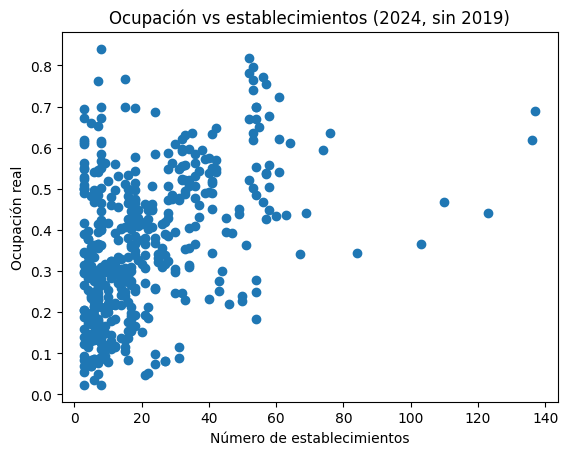

In [61]:
df_2024 = df_plot_ocup[df_plot_ocup["date"].dt.year == 2024]

plt.figure()
plt.scatter(df_2024["Establecimientos"], df_2024["ocupacion_real"])
plt.xlabel("Número de establecimientos")
plt.ylabel("Ocupación real")
plt.title("Ocupación vs establecimientos (2024, sin 2019)")
plt.show()

Qué vemos:
	•	No hay relación lineal clara.
	•	Provincias con pocos establecimientos pueden tener ocupaciones muy altas.
	•	Provincias con muchos establecimientos también pueden tener ocupaciones altas.

👉 Conclusión técnica:
El número de establecimientos NO explica por sí solo la ocupación.

Eso es importante.

Porque significa:
	•	No es simplemente “más oferta = menor ocupación”.
	•	Hay factores estructurales (turismo internacional, clima, posicionamiento, tipo de cliente…).

Insight estratégico

El mercado no está puramente saturado por volumen.
Está segmentado.

## Evolución del personal y la ocupación del Camping

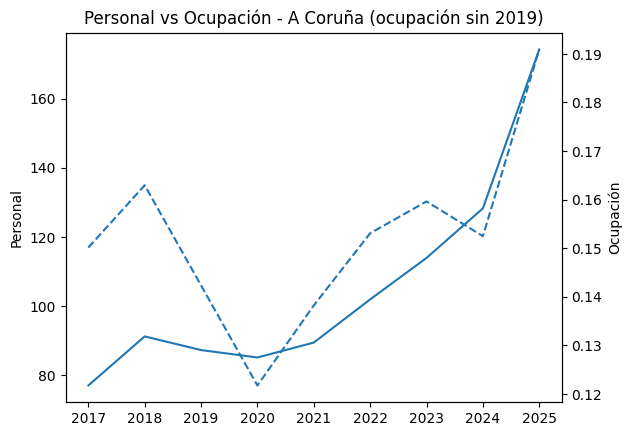

In [62]:
coruna_full = df_plot[df_plot["provincia"].str.startswith("15")]
coruna_ocup = df_plot_ocup[df_plot_ocup["provincia"].str.startswith("15")]

coruna_full["year"] = coruna_full["date"].dt.year
coruna_ocup["year"] = coruna_ocup["date"].dt.year

personal_anual = coruna_full.groupby("year")["Personal"].mean()
ocupacion_anual = coruna_ocup.groupby("year")["ocupacion_real"].mean()

fig, ax1 = plt.subplots()

ax1.plot(personal_anual, label="Personal")
ax1.set_ylabel("Personal")

ax2 = ax1.twinx()
ax2.plot(ocupacion_anual, linestyle="--")
ax2.set_ylabel("Ocupación")

plt.title("Personal vs Ocupación - A Coruña (ocupación sin 2019)")
plt.show()

Gráfico muy interesante.

Lo que se observa:
	•	Desde 2020, personal sube de forma constante.
	•	La ocupación también sube en tendencia.
	•	2025 muestra máximo en ambas.

👉 Hay correlación positiva clara.

Interpretación:
	•	Más personal → mejor servicio → más ocupación.
	•	O al revés: más demanda → se contrata más.

En cualquier caso:
Hay alineación operativa.

Eso es sano.

## Heatmap estacional

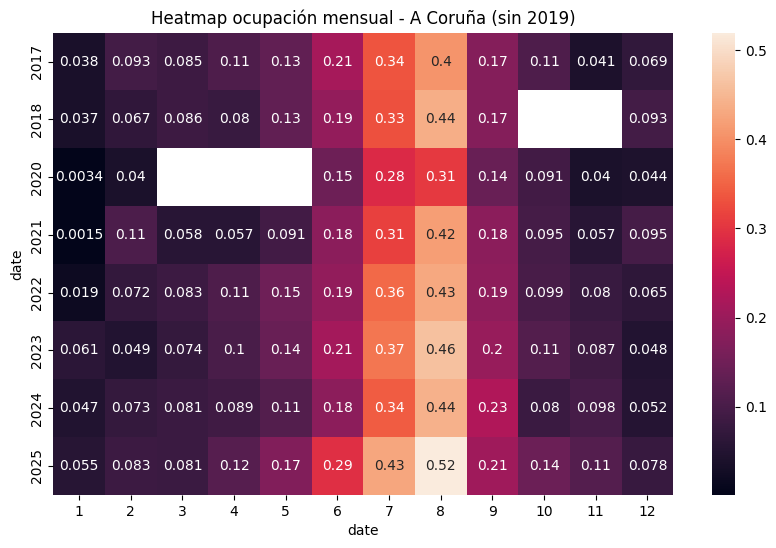

In [63]:
coruna_heat = df_plot_ocup[
    df_plot_ocup["provincia"].str.startswith("15")
]

pivot_heat = coruna_heat.pivot_table(
    index=coruna_heat["date"].dt.year,
    columns=coruna_heat["date"].dt.month,
    values="ocupacion_real",
    aggfunc="mean"
)

import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(pivot_heat, annot=True)
plt.title("Heatmap ocupación mensual - A Coruña (sin 2019)")
plt.show()

In [ ]:
Este es el gráfico más valioso estratégicamente.

Patrón clarísimo:
	•	Julio y agosto son extremadamente dominantes.
	•	Agosto llega a 0.52 en 2025.
	•	Enero-febrero siempre bajos.
	•	Junio y septiembre ya muestran crecimiento.

👉 Mercado hiperestacional.

Eso implica:
	•	Dependencia muy fuerte de 2 meses.
	•	Margen enorme para crecer en mayo, junio y septiembre.

## Ranking provincias por presión en la demanda

/Users/david/Documents/project_demo/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129 (\x81) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


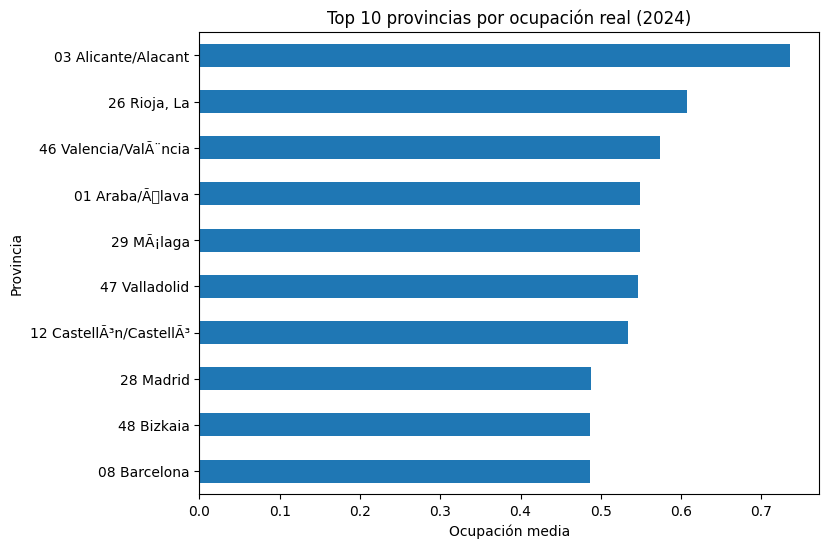

In [65]:
df_2024 = df_plot_ocup[df_plot_ocup["date"].dt.year == 2024]

ranking = (
    df_2024
    .groupby("provincia")["ocupacion_real"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(8,6))
ranking.head(10).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 10 provincias por ocupación real (2024)")
plt.xlabel("Ocupación media")
plt.ylabel("Provincia")
plt.show()

# Conclusiones finales
📌 Conclusiones Finales

1️⃣ El mercado de campings en A Coruña muestra una tendencia creciente desde 2020

Tras excluir el año 2019 debido a una anomalía en la variable Parcelas ocupadas, se observa una recuperación clara post-pandemia y una tendencia estructural ascendente en la ocupación media anual.

Especialmente relevante es el crecimiento sostenido entre 2021 y 2025, donde la ocupación media alcanza máximos del periodo analizado. Esto indica una mejora estructural en la demanda y no solo una recuperación puntual.

⸻

2️⃣ La estacionalidad es extremadamente marcada

El análisis mensual y el heatmap muestran que la demanda se concentra de forma muy intensa en julio y agosto, alcanzando valores significativamente superiores al resto del año.

Esto implica:
	•	Alta dependencia de temporada alta.
	•	Baja utilización de capacidad en meses de invierno.
	•	Oportunidad clara de crecimiento en meses intermedios (mayo, junio y septiembre).

La hiperestacionalidad constituye tanto un riesgo (concentración de ingresos) como una oportunidad estratégica (desestacionalización).

⸻

3️⃣ A Coruña no presenta señales de saturación estructural

En la comparación con provincias similares (Pontevedra, Asturias, Cantabria), A Coruña muestra niveles de ocupación inferiores, aunque con tendencia creciente.

Además, el análisis de dispersión entre ocupación y número de establecimientos no evidencia una relación negativa clara. Esto sugiere que el incremento de oferta no está provocando una caída significativa en la ocupación media.

Por tanto, el mercado no parece estar saturado en términos estructurales.

⸻

4️⃣ Crecimiento de personal alineado con la demanda

La evolución del personal empleado presenta una correlación positiva con la ocupación, especialmente desde 2021. Esto indica que el sector está ajustando su capacidad operativa al crecimiento de la demanda.

Este comportamiento es consistente con un mercado en expansión saludable.

⸻

5️⃣ Implicaciones estratégicas para una posible ampliación

Considerando:
	•	Tendencia creciente de ocupación en temporada alta.
	•	Ausencia de señales claras de saturación.
	•	Incremento paralelo de personal y demanda.
	•	Diferencial respecto a provincias más tensionadas.

Se puede concluir que el mercado presenta condiciones favorables para una ampliación moderada, especialmente si se orienta a optimizar la capacidad en temporada alta y mejorar la ocupación en meses intermedios.

No obstante, la fuerte estacionalidad sugiere que cualquier inversión debería acompañarse de estrategias de diversificación de demanda fuera de julio y agosto.

⸻

🎯 Conclusión global

El análisis realizado indica que el sector de campings en A Coruña se encuentra en una fase de crecimiento estructural moderado, con alta estacionalidad pero sin signos evidentes de saturación, lo que abre oportunidades estratégicas de expansión bajo una planificación prudente.